# <center>DataLab Cup 4: Recommender Systems</center>
<center>Shan-Hung Wu & DataLab</center>
<center>Fall 2023</center>

## Platform: [Kaggle](https://www.kaggle.com/t/b06e248a3827434f80c4fdc6009d5fe0)

Please download the dataset and the environment source code from Kaggle.

## Overview

In this competition, your goal is to design a recommender system that suggests news articles to users. The performance of your recommender system will be assessed using a simulation environment.

At each timestep, the simulation environment randomly selects an active user with a given `user_id`. Once you receive this `user_id`, your recommender system must generate a slate **(a list of 5 distinct `item_ids` to recommend to the current user)** and pass it to the environment. The environment then uses its internal information to determine which item the user will choose from the recommended list (with some degree of stochasticity) or decide not to choose any item due to a lack of interest.

Each user has a latent patience value (invisible to your recommender system), which slightly increases when an item is chosen and drastically decreases when no item is chosen in each round. If a user's patience drops below 0 or the user runs out of the time budget (2000 timesteps), the user leaves the environment. The chosen `item_id` (or `-1` if no item is chosen) and whether the current user stays (`True`) or leaves (`False`) are returned as the result of recommending a slate of items. A new user (if any) will be randomly selected for recommendations in the next timestep after the response of the current user is generated.

Your recommender system should continue recommending items to the current user at each timestep as long as there are still active users in the environment. The simulation process terminates after all users have left the system.

**Your goal is to maximize the session length of each user.** The session length is defined as the number of timesteps a user interacts with your recommender system before leaving the environment. The calculated session length score, normalized to the range of 0 ~ 1, will be provided by the simulation environment after the completion of the simulation process.

In [33]:
import os
import random

import numpy as np
import pandas as pd
from tqdm import tqdm

from evaluation.environment import TrainingEnvironment, TestingEnvironment

import tensorflow as tf
import matplotlib.pyplot as plt

In [34]:
# Official hyperparameters for this competition (do not modify)
N_TRAIN_USERS = 1000
N_TEST_USERS = 2000
N_ITEMS = 209527
HORIZON = 2000
TEST_EPISODES = 5
SLATE_SIZE = 5

## Datasets

In this competition, we won't provide a substantial user-item interaction dataset. Instead, limited information (3 items per user) on historical interactions will be available. To train your recommender system effectively, you need to employ a recommender policy to interact with the training environment and collect additional interaction data.

We will introduce the side-information datasets provided in the following sections.

In [35]:
# Dataset paths
USER_DATA = os.path.join('dataset', 'user_data.json')
ITEM_DATA = os.path.join('dataset', 'item_data.json')

# Output file path
OUTPUT_PATH = os.path.join('output', 'output.csv')

## User Data

In the **training environment**, there are a total of **1000 users** identified by IDs ranging from 0 to 999. For the **testing environment**, there are **2000 users** with IDs ranging from 0 to 1999. The **testing environment includes the same 1000 users found in the training environment** (user 0 to user 999), and an additional 1000 new users (user 1000 to user 1999) are introduced.

For all 2000 users, we provide you with the **past 3 clicked item IDs of each user**. Let's examine the user dataset.

In [36]:
df_user = pd.read_json(USER_DATA, lines=True)
df_user

,user_id,history
0,0,"[42558, 65272, 13353]"
1,1,"[146057, 195688, 143652]"
2,2,"[67551, 85247, 33714]"
3,3,"[116097, 192703, 103229]"
4,4,"[68756, 140123, 135289]"
...,...,...
1995,1995,"[95090, 131393, 130239]"
1996,1996,"[2360, 147130, 8145]"
1997,1997,"[99794, 138694, 157888]"
1998,1998,"[55561, 60372, 51442]"


In [37]:
# 使用 explode 將 history 列展開為多行
df_clicked = df_user.explode('history')

# 將點擊過的新欄位設為1
df_clicked['clicked'] = 1

# 重新設置索引
df_clicked.reset_index(drop=True, inplace=True)

df_clicked['user_id'] = df_clicked['user_id'].astype(int)
df_clicked['history'] = df_clicked['history'].astype(int)
df_clicked['clicked'] = df_clicked['clicked'].astype(int)

# 顯示處理後的 DataFrame
print(df_clicked)

      user_id  history  clicked
0           0    42558        1
1           0    65272        1
2           0    13353        1
3           1   146057        1
4           1   195688        1
...       ...      ...      ...
5995     1998    60372        1
5996     1998    51442        1
5997     1999   125409        1
5998     1999    77906        1
5999     1999   124792        1

[6000 rows x 3 columns]


## Item Data

Both the training and testing environments share a common pool of **209527 items** as their item candidate pool. For the side information of these items, we provide text descriptions for each news article. The item dataset is derived from the [News Category Dataset](https://www.kaggle.com/datasets/rmisra/news-category-dataset). It's important to note that you should only use the dataset provided by us. Utilizing the original dataset, which contains extra information, will be considered as cheating. Let's explore the item dataset.

In [38]:
df_item = pd.read_json(ITEM_DATA, lines=True)
df_item

,item_id,headline,short_description
0,0,Over 4 Million Americans Roll Up Sleeves For O...,Health experts said it is too early to predict...
1,1,"American Airlines Flyer Charged, Banned For Li...",He was subdued by passengers and crew when he ...
2,2,23 Of The Funniest Tweets About Cats And Dogs ...,"""Until you have a dog you don't understand wha..."
3,3,The Funniest Tweets From Parents This Week (Se...,"""Accidentally put grown-up toothpaste on my to..."
4,4,Woman Who Called Cops On Black Bird-Watcher Lo...,Amy Cooper accused investment firm Franklin Te...
...,...,...,...
209522,209522,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,Verizon Wireless and AT&T are already promotin...
209523,209523,Maria Sharapova Stunned By Victoria Azarenka I...,"Afterward, Azarenka, more effusive with the pr..."
209524,209524,"Giants Over Patriots, Jets Over Colts Among M...","Leading up to Super Bowl XLVI, the most talked..."
209525,209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,CORRECTION: An earlier version of this story i...


## Simulation Environments

We offer two simulation environments in this competition: `TrainingEnvironment` and `TestingEnvironment`. The only distinction between the two environments is the number of users, with 1000 for training and 2000 for testing. All public methods for both environments behave the same since they share the same base class.

**Important Note: Ensure that you collect interaction data only by accessing the environment through the designated public methods listed below. Directly accessing or modifying any file or code in the `evaluation` directory, or retrieving internal attributes and states of the environment (including all attributes / methods starting with an underscore `_`), will be considered as cheating.**

## Environment Classes

### <kbd>class</kbd> `TrainingEnvironment`
Class for the training environment. Contains first 1000 users with user ID ranging from 0 to 999. 

### <kbd>class</kbd> `TestingEnvironment`
Class for the testing environment. Contains all 2000 users with user ID ranging from 0 to 1999. 

## Environment Public Methods

**Note that both `TrainingEnvironment` and `TestingEnvironment` shares the same set of public methods.**

---

### <kbd>function</kbd> `reset`


```python
reset() → None
```

<br/>
Reset the environment to its initial parameters and states. 

---

### <kbd>function</kbd> `has_next_state`


```python
has_next_state() → bool
```

<br/>
Verify whether the next state exists. The next state is considered to exist if there is at least one user still present in the environment. 

**Returns:**

  - `True` if the next state exists, `False` otherwise. 

---

### <kbd>function</kbd> `get_state`


```python
get_state() → int
```

<br/>
Get the current state (the user ID of the current user). 

**Returns:**
 
 - <b>``int``</b>:  The user ID of the current user, or `-1` if there are no active users in the environment. 

---

### <kbd>function</kbd> `get_response`


```python
get_response(slate: list) → tuple[int, bool]
```

<br/>
Send the recommended slate (list of 5 distinct item IDs) and get the response from the current user. The internal user state will be updated according to the response, and a random user will be selected to be the next user (next state). 

**Args:**
 
 - <b>`slate`</b>:  `list[int]`  A list of 5 distinct item IDs to be recommended. 

**Returns:**

 - <b>`tuple[int, bool]`</b>:  The first entry indicates the `item ID` chosen by the user, or `-1` if the user decides not to choose any item.  The second entry represents whether the user is still in the environment after this interaction round. `True` if the user stays, `False` if the user leaves. 

**Raises:**
 
 - <b>``AssertionError``</b>:  If the slate length is not 5, contains duplicates or out-of-range item IDs, or if there are no active users in the environment. 

---

### <kbd>function</kbd> `get_score`


```python
get_score() → list[float]
```

<br/>
Get the normalized session length score (0 ~ 1) for each user. 

**Returns:**
 
 - <b>``list[float]``</b>:  A list containing the normalized session length score for each user. 

## Training

The implementation of the recommender algorithm is left to you. If you're in need of ideas, you can refer to the [Recommender Systems Tutorial](https://nthu-datalab.github.io/ml/labs/recommender-systems-tutorial/recommender-systems-tutorial.html) notebook in Lecture 16. Here, we'll just provide some example use cases of the public methods.

**Hint:** If you're looking for inspiration, consider starting by collecting interaction data from the environment using your initial recommender policy. Afterward, improve your model with this data, and iterate through this collect-then-train loop.

**Important Note: Ensure that you save your model weights after training. You will need to load a set of model weights trained exclusively on the training environment at the beginning of each test episode.**

In [39]:
# Get bias_mu
BIAS_MU = df_clicked['clicked'].mean()
print('bias_mu = ', BIAS_MU)

bias_mu =  1.0


In [40]:
class FunkSVDRecommender(tf.keras.Model):
    '''
    Simplified Funk-SVD recommender model
    '''

    def __init__(self, m_users: int, n_items: int, bias_mu, embedding_size: int, learning_rate: float,
                 regularization_train: bool, regularization_update: bool, seed: int):
        '''
        Constructor of the model
        '''
        super().__init__()
        self.m = m_users
        self.n = n_items
        self.k = embedding_size
        self.lr = learning_rate
        self.reg_train = regularization_train
        self.reg_update = regularization_update
        self.seed = seed
        self.B_mu = tf.constant([bias_mu])

        # user embeddings P
        self.P = tf.Variable(tf.keras.initializers.RandomNormal()(shape=(self.m, self.k)))

        # item embeddings Q
        self.Q = tf.Variable(tf.keras.initializers.RandomNormal()(shape=(self.n, self.k)))
        
        # bias term
        self.B_user = tf.Variable(tf.keras.initializers.RandomNormal(seed=self.seed)(shape=(self.m, 1)))
        self.B_item = tf.Variable(tf.keras.initializers.RandomNormal(seed=self.seed)(shape=(self.n, 1)))

        # optimizer
        self.optimizer = tf.optimizers.Adam(learning_rate=self.lr)

    @tf.function
    def call(self, user_ids: tf.Tensor, item_ids: tf.Tensor) -> tf.Tensor:
        '''
        Forward pass used in training and validating
        '''
        # dot product the user and item embeddings corresponding to the observed interaction pairs to produce predictions
        y_pred = tf.reduce_sum(tf.gather(self.P, indices=user_ids) * tf.gather(self.Q, indices=item_ids), axis=1)
        
        y_pred = tf.add(y_pred, tf.squeeze(tf.gather(self.B_user, indices=user_ids)))
        y_pred = tf.add(y_pred, tf.squeeze(tf.gather(self.B_item, indices=item_ids)))

        return y_pred

    @tf.function
    def compute_loss(self, y_true: tf.Tensor, y_pred: tf.Tensor, regularization: bool) -> tf.Tensor:
        '''
        Compute the MSE loss of the model
        '''
        # loss = tf.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
        
        if regularization:
            loss = tf.losses.binary_crossentropy(y_true, y_pred)
            # loss = tf.losses.mean_squared_error(y_true, y_pred)
            reg = 0.01 * (tf.nn.l2_loss(self.Q) + tf.nn.l2_loss(self.P) +
                          tf.nn.l2_loss(self.B_item) + tf.nn.l2_loss(self.B_user))
            loss += reg
        else:
            loss = tf.losses.binary_crossentropy(y_true, y_pred)
            # loss = tf.losses.mean_squared_error(y_true, y_pred)

        return loss

    @tf.function
    def train_step(self, data: tf.Tensor) -> tf.Tensor:
        '''
        Train the model with one batch
        data: batched user-item interactions
        each record in data is in the format [user_id, history, clicked]
        '''
        user_ids = tf.cast(data[:, 0], dtype=tf.int32)
        item_ids = tf.cast(data[:, 1], dtype=tf.int32)
        y_true = tf.cast(data[:, 2], dtype=tf.float32)

        # compute loss
        with tf.GradientTape() as tape:
            y_pred = self(user_ids, item_ids)
            loss = self.compute_loss(y_true, y_pred, self.reg_train)

        # compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # update weights
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return loss

    @tf.function
    def eval_predict_onestep(self, user_id: int) -> tf.Tensor:
        '''
        Retrieve and return the NewsIDs of the 5 recommended news given a query
        You should return a tf.Tensor with shape=(5,)
        '''
        user_id = tf.cast(user_id, tf.int32)
        
        # dot product the selected user and all item embeddings to produce predictions
        y_pred = tf.reduce_sum(tf.gather(self.P, user_id) * self.Q, axis=1)
        
        y_pred = tf.add(tf.gather(self.B_user, user_id), y_pred)
        y_pred = tf.add(tf.squeeze(self.B_item), y_pred)

        # select the top 5 items with highest scores in y_pred
        y_top_5 = tf.math.top_k(y_pred, k=5).indices

        return y_top_5

In [41]:
@tf.function
def log2(x: tf.Tensor) -> tf.Tensor:
    return tf.math.log(tf.cast(x, tf.float32)) / tf.math.log(2.)

@tf.function
def ndcg_at_10(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    y_pred = y_pred[:10]
    idx = tf.equal(tf.cast(y_pred, tf.int32), tf.cast(y_true, tf.int32))
    if tf.reduce_sum(tf.cast(idx, tf.int32)) > 0:
        return 1. / log2(2 + tf.argmax(idx))
    else:
        return tf.constant(0.)

@tf.function
def recall_at_10(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    y_pred = y_pred[:10]
    idx = tf.equal(tf.cast(y_pred, tf.int32), tf.cast(y_true, tf.int32))
    if tf.reduce_sum(tf.cast(idx, tf.int32)) > 0:
        return tf.constant(1.)
    else:
        return tf.constant(0.)

def evaluate(model: tf.keras.Model, dataset: tf.data.Dataset) -> tuple:
    '''
    For each data point in the dataset:
    data[0] is the UserID
    data[1] is the NewsID 
    data[2] is the Clicked
    '''
    ndcg_scores = []
    recall_scores = []

    for data in tqdm(dataset, desc='Evaluating'):
        # query the model to make predictions if the observed event is a positive interaction (ratings >= 4)
        if data[2] == 1:
            y_pred = model.eval_predict_onestep(tf.gather(data, (0, 2)))
            y_true = tf.gather(data, 1)
            ndcg = ndcg_at_10(y_true, y_pred)
            recall = recall_at_10(y_true, y_pred)
            ndcg_scores.append(ndcg)
            recall_scores.append(recall)

    ndcg_result = tf.reduce_mean(ndcg_scores).numpy()
    recall_result = tf.reduce_mean(recall_scores).numpy()

    return ndcg_result, recall_result

In [42]:
# hyperparameters
EMBEDDING_SIZE = 256
BATCH_SIZE = 512
N_EPOCHS = 200
LEARNING_RATE = 1e-4
SEED = 0

# bad result if adding regularization
REGULARIZATION_TRAIN = False
REGULARIZATION_UPDATE = False

Epoch 1:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.34it/s]


Epoch 1 train_loss: 9.2847

Epoch 2:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.46it/s]


Epoch 2 train_loss: 9.1465

Epoch 3:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.25it/s]


Epoch 3 train_loss: 9.0700

Epoch 4:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.24it/s]


Epoch 4 train_loss: 9.0110

Epoch 5:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.39it/s]


Epoch 5 train_loss: 8.9633

Epoch 6:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.54it/s]


Epoch 6 train_loss: 8.9110

Epoch 7:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.82it/s]


Epoch 7 train_loss: 8.8600

Epoch 8:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.39it/s]


Epoch 8 train_loss: 8.8110

Epoch 9:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.87it/s]


Epoch 9 train_loss: 8.7678

Epoch 10:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.85it/s]


Epoch 10 train_loss: 8.7333

Epoch 11:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.53it/s]


Epoch 11 train_loss: 8.7009

Epoch 12:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.40it/s]


Epoch 12 train_loss: 8.6720

Epoch 13:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.79it/s]


Epoch 13 train_loss: 8.6482

Epoch 14:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.20it/s]


Epoch 14 train_loss: 8.6255

Epoch 15:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.81it/s]


Epoch 15 train_loss: 8.6053

Epoch 16:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.53it/s]


Epoch 16 train_loss: 8.5838

Epoch 17:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.49it/s]


Epoch 17 train_loss: 8.5623

Epoch 18:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.76it/s]


Epoch 18 train_loss: 8.5392

Epoch 19:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.20it/s]


Epoch 19 train_loss: 8.5195

Epoch 20:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.60it/s]


Epoch 20 train_loss: 8.5005

Epoch 21:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.84it/s]


Epoch 21 train_loss: 8.4775

Epoch 22:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.88it/s]


Epoch 22 train_loss: 8.4539

Epoch 23:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.06it/s]


Epoch 23 train_loss: 8.4300

Epoch 24:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.42it/s]


Epoch 24 train_loss: 8.4090

Epoch 25:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.89it/s]


Epoch 25 train_loss: 8.3894

Epoch 26:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.91it/s]


Epoch 26 train_loss: 8.3702

Epoch 27:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.40it/s]


Epoch 27 train_loss: 8.3494

Epoch 28:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.59it/s]


Epoch 28 train_loss: 8.3288

Epoch 29:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.99it/s]


Epoch 29 train_loss: 8.3112

Epoch 30:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.92it/s]


Epoch 30 train_loss: 8.2946

Epoch 31:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.76it/s]


Epoch 31 train_loss: 8.2776

Epoch 32:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.85it/s]


Epoch 32 train_loss: 8.2616

Epoch 33:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.12it/s]


Epoch 33 train_loss: 8.2443

Epoch 34:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.06it/s]


Epoch 34 train_loss: 8.2268

Epoch 35:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.74it/s]


Epoch 35 train_loss: 8.2114

Epoch 36:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.59it/s]


Epoch 36 train_loss: 8.1959

Epoch 37:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.05it/s]


Epoch 37 train_loss: 8.1768

Epoch 38:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.85it/s]


Epoch 38 train_loss: 8.1587

Epoch 39:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.53it/s]


Epoch 39 train_loss: 8.1432

Epoch 40:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.80it/s]


Epoch 40 train_loss: 8.1277

Epoch 41:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 62.40it/s]

Epoch 41 train_loss: 8.1145

Epoch 42:



Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.44it/s]


Epoch 42 train_loss: 8.1036

Epoch 43:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.61it/s]


Epoch 43 train_loss: 8.0875

Epoch 44:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.66it/s]


Epoch 44 train_loss: 8.0682

Epoch 45:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.44it/s]


Epoch 45 train_loss: 8.0516

Epoch 46:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.22it/s]


Epoch 46 train_loss: 8.0367

Epoch 47:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.37it/s]


Epoch 47 train_loss: 8.0226

Epoch 48:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.45it/s]


Epoch 48 train_loss: 8.0091

Epoch 49:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.53it/s]


Epoch 49 train_loss: 7.9954

Epoch 50:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.97it/s]


Epoch 50 train_loss: 7.9829

Epoch 51:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.69it/s]


Epoch 51 train_loss: 7.9687

Epoch 52:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.56it/s]


Epoch 52 train_loss: 7.9529

Epoch 53:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.48it/s]


Epoch 53 train_loss: 7.9399

Epoch 54:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.20it/s]


Epoch 54 train_loss: 7.9307

Epoch 55:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.83it/s]


Epoch 55 train_loss: 7.9200

Epoch 56:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.42it/s]


Epoch 56 train_loss: 7.9079

Epoch 57:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.88it/s]


Epoch 57 train_loss: 7.8944

Epoch 58:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.49it/s]


Epoch 58 train_loss: 7.8800

Epoch 59:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.87it/s]


Epoch 59 train_loss: 7.8699

Epoch 60:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.49it/s]


Epoch 60 train_loss: 7.8587

Epoch 61:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 62.09it/s]

Epoch 61 train_loss: 7.8455

Epoch 62:



Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.37it/s]


Epoch 62 train_loss: 7.8373

Epoch 63:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.22it/s]


Epoch 63 train_loss: 7.8271

Epoch 64:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.18it/s]


Epoch 64 train_loss: 7.8134

Epoch 65:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.91it/s]


Epoch 65 train_loss: 7.8038

Epoch 66:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.02it/s]


Epoch 66 train_loss: 7.7952

Epoch 67:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.35it/s]


Epoch 67 train_loss: 7.7869

Epoch 68:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.41it/s]


Epoch 68 train_loss: 7.7794

Epoch 69:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.57it/s]


Epoch 69 train_loss: 7.7734

Epoch 70:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.53it/s]


Epoch 70 train_loss: 7.7663

Epoch 71:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.91it/s]


Epoch 71 train_loss: 7.7564

Epoch 72:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.32it/s]


Epoch 72 train_loss: 7.7445

Epoch 73:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.21it/s]


Epoch 73 train_loss: 7.7344

Epoch 74:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.90it/s]


Epoch 74 train_loss: 7.7207

Epoch 75:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.14it/s]


Epoch 75 train_loss: 7.7085

Epoch 76:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.04it/s]


Epoch 76 train_loss: 7.6978

Epoch 77:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.75it/s]


Epoch 77 train_loss: 7.6890

Epoch 78:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.42it/s]


Epoch 78 train_loss: 7.6802

Epoch 79:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 62.17it/s]


Epoch 79 train_loss: 7.6707

Epoch 80:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.85it/s]


Epoch 80 train_loss: 7.6616

Epoch 81:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 62.42it/s]

Epoch 81 train_loss: 7.6480

Epoch 82:



Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.80it/s]


Epoch 82 train_loss: 7.6372

Epoch 83:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.75it/s]


Epoch 83 train_loss: 7.6237

Epoch 84:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.48it/s]


Epoch 84 train_loss: 7.6139

Epoch 85:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.60it/s]


Epoch 85 train_loss: 7.6085

Epoch 86:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.82it/s]


Epoch 86 train_loss: 7.6025

Epoch 87:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.73it/s]


Epoch 87 train_loss: 7.5941

Epoch 88:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.92it/s]


Epoch 88 train_loss: 7.5840

Epoch 89:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.82it/s]


Epoch 89 train_loss: 7.5734

Epoch 90:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.49it/s]


Epoch 90 train_loss: 7.5647

Epoch 91:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.14it/s]


Epoch 91 train_loss: 7.5557

Epoch 92:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.53it/s]


Epoch 92 train_loss: 7.5472

Epoch 93:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 62.05it/s]


Epoch 93 train_loss: 7.5357

Epoch 94:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.53it/s]


Epoch 94 train_loss: 7.5244

Epoch 95:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.00it/s]


Epoch 95 train_loss: 7.5161

Epoch 96:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.09it/s]


Epoch 96 train_loss: 7.5063

Epoch 97:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.60it/s]


Epoch 97 train_loss: 7.4986

Epoch 98:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.72it/s]


Epoch 98 train_loss: 7.4889

Epoch 99:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.49it/s]


Epoch 99 train_loss: 7.4776

Epoch 100:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.92it/s]


Epoch 100 train_loss: 7.4661

Epoch 101:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 62.43it/s]


Epoch 101 train_loss: 7.4523

Epoch 102:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.01it/s]


Epoch 102 train_loss: 7.4400

Epoch 103:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.98it/s]


Epoch 103 train_loss: 7.4317

Epoch 104:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.44it/s]


Epoch 104 train_loss: 7.4236

Epoch 105:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.60it/s]


Epoch 105 train_loss: 7.4164

Epoch 106:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.29it/s]


Epoch 106 train_loss: 7.4087

Epoch 107:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.53it/s]


Epoch 107 train_loss: 7.4010

Epoch 108:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.53it/s]


Epoch 108 train_loss: 7.3932

Epoch 109:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.53it/s]


Epoch 109 train_loss: 7.3866

Epoch 110:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.22it/s]


Epoch 110 train_loss: 7.3802

Epoch 111:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.38it/s]


Epoch 111 train_loss: 7.3712

Epoch 112:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.71it/s]


Epoch 112 train_loss: 7.3620

Epoch 113:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.34it/s]


Epoch 113 train_loss: 7.3526

Epoch 114:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.98it/s]


Epoch 114 train_loss: 7.3460

Epoch 115:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.99it/s]


Epoch 115 train_loss: 7.3372

Epoch 116:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.60it/s]


Epoch 116 train_loss: 7.3271

Epoch 117:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.73it/s]


Epoch 117 train_loss: 7.3169

Epoch 118:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.44it/s]


Epoch 118 train_loss: 7.3050

Epoch 119:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.81it/s]


Epoch 119 train_loss: 7.2991

Epoch 120:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.04it/s]


Epoch 120 train_loss: 7.2914

Epoch 121:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.77it/s]


Epoch 121 train_loss: 7.2830

Epoch 122:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.17it/s]


Epoch 122 train_loss: 7.2757

Epoch 123:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.46it/s]


Epoch 123 train_loss: 7.2704

Epoch 124:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.40it/s]


Epoch 124 train_loss: 7.2653

Epoch 125:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.54it/s]


Epoch 125 train_loss: 7.2559

Epoch 126:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.68it/s]


Epoch 126 train_loss: 7.2484

Epoch 127:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.90it/s]


Epoch 127 train_loss: 7.2430

Epoch 128:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.73it/s]


Epoch 128 train_loss: 7.2367

Epoch 129:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.21it/s]


Epoch 129 train_loss: 7.2277

Epoch 130:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 62.17it/s]


Epoch 130 train_loss: 7.2187

Epoch 131:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.53it/s]


Epoch 131 train_loss: 7.2093

Epoch 132:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.18it/s]


Epoch 132 train_loss: 7.2008

Epoch 133:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.07it/s]


Epoch 133 train_loss: 7.1943

Epoch 134:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.93it/s]


Epoch 134 train_loss: 7.1861

Epoch 135:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.72it/s]


Epoch 135 train_loss: 7.1784

Epoch 136:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.68it/s]


Epoch 136 train_loss: 7.1708

Epoch 137:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.34it/s]


Epoch 137 train_loss: 7.1641

Epoch 138:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.18it/s]


Epoch 138 train_loss: 7.1575

Epoch 139:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.55it/s]


Epoch 139 train_loss: 7.1528

Epoch 140:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.63it/s]


Epoch 140 train_loss: 7.1468

Epoch 141:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.84it/s]


Epoch 141 train_loss: 7.1391

Epoch 142:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.15it/s]


Epoch 142 train_loss: 7.1305

Epoch 143:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.82it/s]


Epoch 143 train_loss: 7.1235

Epoch 144:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.82it/s]


Epoch 144 train_loss: 7.1172

Epoch 145:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.29it/s]


Epoch 145 train_loss: 7.1058

Epoch 146:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.42it/s]


Epoch 146 train_loss: 7.0944

Epoch 147:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.17it/s]


Epoch 147 train_loss: 7.0853

Epoch 148:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.19it/s]


Epoch 148 train_loss: 7.0787

Epoch 149:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.41it/s]


Epoch 149 train_loss: 7.0709

Epoch 150:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.71it/s]


Epoch 150 train_loss: 7.0597

Epoch 151:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.10it/s]


Epoch 151 train_loss: 7.0464

Epoch 152:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.07it/s]


Epoch 152 train_loss: 7.0371

Epoch 153:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.84it/s]


Epoch 153 train_loss: 7.0284

Epoch 154:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.78it/s]


Epoch 154 train_loss: 7.0204

Epoch 155:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.52it/s]


Epoch 155 train_loss: 7.0145

Epoch 156:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.85it/s]


Epoch 156 train_loss: 7.0087

Epoch 157:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.48it/s]


Epoch 157 train_loss: 7.0014

Epoch 158:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.20it/s]


Epoch 158 train_loss: 6.9934

Epoch 159:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.11it/s]


Epoch 159 train_loss: 6.9890

Epoch 160:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.55it/s]


Epoch 160 train_loss: 6.9848

Epoch 161:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.15it/s]

Epoch 161 train_loss: 6.9789

Epoch 162:



Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.14it/s]


Epoch 162 train_loss: 6.9720

Epoch 163:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.87it/s]


Epoch 163 train_loss: 6.9665

Epoch 164:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.03it/s]


Epoch 164 train_loss: 6.9602

Epoch 165:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.28it/s]


Epoch 165 train_loss: 6.9537

Epoch 166:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.34it/s]


Epoch 166 train_loss: 6.9457

Epoch 167:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.10it/s]


Epoch 167 train_loss: 6.9365

Epoch 168:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.45it/s]


Epoch 168 train_loss: 6.9263

Epoch 169:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.71it/s]


Epoch 169 train_loss: 6.9203

Epoch 170:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.63it/s]


Epoch 170 train_loss: 6.9128

Epoch 171:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.99it/s]


Epoch 171 train_loss: 6.9059

Epoch 172:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.44it/s]


Epoch 172 train_loss: 6.9013

Epoch 173:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.29it/s]


Epoch 173 train_loss: 6.8972

Epoch 174:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.11it/s]


Epoch 174 train_loss: 6.8916

Epoch 175:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.00it/s]


Epoch 175 train_loss: 6.8877

Epoch 176:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.29it/s]


Epoch 176 train_loss: 6.8834

Epoch 177:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.29it/s]


Epoch 177 train_loss: 6.8809

Epoch 178:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.60it/s]


Epoch 178 train_loss: 6.8785

Epoch 179:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.96it/s]


Epoch 179 train_loss: 6.8761

Epoch 180:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.32it/s]


Epoch 180 train_loss: 6.8728

Epoch 181:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.50it/s]


Epoch 181 train_loss: 6.8694

Epoch 182:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.96it/s]


Epoch 182 train_loss: 6.8652

Epoch 183:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.40it/s]


Epoch 183 train_loss: 6.8607

Epoch 184:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.89it/s]


Epoch 184 train_loss: 6.8563

Epoch 185:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.40it/s]


Epoch 185 train_loss: 6.8521

Epoch 186:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.19it/s]


Epoch 186 train_loss: 6.8498

Epoch 187:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.05it/s]


Epoch 187 train_loss: 6.8477

Epoch 188:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.08it/s]


Epoch 188 train_loss: 6.8456

Epoch 189:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.69it/s]


Epoch 189 train_loss: 6.8426

Epoch 190:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.34it/s]


Epoch 190 train_loss: 6.8391

Epoch 191:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.32it/s]


Epoch 191 train_loss: 6.8353

Epoch 192:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.91it/s]


Epoch 192 train_loss: 6.8332

Epoch 193:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.59it/s]


Epoch 193 train_loss: 6.8313

Epoch 194:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.65it/s]


Epoch 194 train_loss: 6.8280

Epoch 195:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.84it/s]


Epoch 195 train_loss: 6.8229

Epoch 196:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.25it/s]


Epoch 196 train_loss: 6.8186

Epoch 197:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.97it/s]


Epoch 197 train_loss: 6.8146

Epoch 198:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.79it/s]


Epoch 198 train_loss: 6.8097

Epoch 199:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.22it/s]


Epoch 199 train_loss: 6.8068

Epoch 200:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.02it/s]


Epoch 200 train_loss: 6.8050



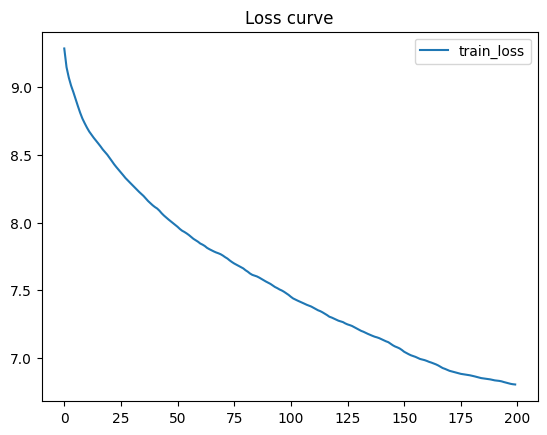

In [43]:
CKP_DIR_INIT = './weight/init/'
CKP_DIR = './weight'

# prepare datasets
dataset_train = tf.data.Dataset.from_tensor_slices(df_clicked)
dataset_train = dataset_train.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

M_USERS = 6000

# build the model
model = FunkSVDRecommender(m_users=M_USERS, 
                           n_items=N_ITEMS,
                           bias_mu=BIAS_MU,
                           embedding_size=EMBEDDING_SIZE, 
                           learning_rate=LEARNING_RATE,
                           regularization_train=REGULARIZATION_TRAIN,
                           regularization_update=REGULARIZATION_UPDATE,
                           seed=SEED)

# train the model
train_losses = []

for epoch in range(1, N_EPOCHS + 1):
    train_loss = []
    print(f'Epoch {epoch}:')

    # training
    for data in tqdm(dataset_train, desc='Training'):
        loss = model.train_step(data)
        train_loss.append(loss.numpy())

    # record losses
    avg_train_loss = np.mean(train_loss)
    train_losses.append(avg_train_loss)

    # print losses
    print(f'Epoch {epoch} train_loss: {avg_train_loss:.4f}\n')

    if epoch % 20 == 0:
        model.save_weights(os.path.join(CKP_DIR_INIT, f'ckpt-{epoch}'))
        
# plot the training curve
plt.plot(train_losses, label='train_loss')
plt.legend(loc='upper right')
plt.title('Loss curve')
plt.show()

In [44]:
def train_model(model, dataset_train, N_EPOCHS, CKP_PATH):
    # train the model
    train_losses = []

    for epoch in range(1, N_EPOCHS + 1):
        train_loss = []
        print(f'Epoch {epoch}:')

        # training
        for data in tqdm(dataset_train, desc='Training'):
            loss = model.train_step(data)
            train_loss.append(loss.numpy())

        # record losses
        avg_train_loss = np.mean(train_loss)
        train_losses.append(avg_train_loss)

        # print losses
        print(f'Epoch {epoch} train_loss: {avg_train_loss:.4f}\n')

        if epoch % 10 == 0:
            model.save_weights(os.path.join(CKP_PATH, f'ckpt_EPOCH_{epoch}'))

In [45]:
# Initialize the training environment
train_env = TrainingEnvironment()

# Reset the training environment (this can be useful when you have finished one episode of simulation and do not want to re-initialize a new environment)
train_env.reset()

# Check if there exist any active users in the environment
env_has_next_state = train_env.has_next_state()
print(f'There is {"still some" if env_has_next_state else "no"} active users in the training environment.')

# Get the current user ID
user_id = train_env.get_state()
print(f'The current user is user {user_id}.')

# Get the response of recommending the slate to the current user
model.load_weights('./weight/init/ckpt-200')
recommended_items = model.eval_predict_onestep(user_id)
slate = recommended_items

# slate = [0, 1, 2, 3, 4]

clicked_id, in_environment = train_env.get_response(slate)
print(f'The click result of recommending {slate} to user {user_id} is {f"item {clicked_id}" if clicked_id != -1 else f"{clicked_id} (no click)"}.')
print(f'User {user_id} {"is still in" if in_environment else "leaves"} the environment.')

# Get the normalized session length score of all users
train_score = train_env.get_score()
df_train_score = pd.DataFrame([[user_id, score] for user_id, score in enumerate(train_score)], columns=['user_id', 'avg_score'])
df_train_score

There is still some active users in the training environment.
The current user is user 599.
The click result of recommending [160632  91813  26037  49929 164838] to user 599 is -1 (no click).
User 599 is still in the environment.


,user_id,avg_score
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
995,995,0.0
996,996,0.0
997,997,0.0
998,998,0.0


## Testing

While testing, you are allowed to update your model. However, please adhere to the following rules:

1. Follow the testing template provided below. Modify only the sections marked as `[TODO]`. Additionally, please carefully follow the instructions specified in each `[TODO]` section. Modifying other sections or not adhering to the instructions is strictly forbidden.

2. Limit model updates to one testing episode. During testing-time updates, follow these steps: (a) **Load your model weights** trained exclusively on the training environment. (b) Run the testing environment and update your model with the collected data **during the testing process**. (c) Obtain the score for this testing episode and **delete your model weights since they now contain some testing information**. **You should not save the model weights trained on the testing environment for another testing episode. Doing so will be regarded as cheating.**

3. Due to the randomness in the user decision process, **run the testing process 5 times** and calculate the **average session length** for each user as the final score. This part has been covered for you.

After completing the testing process, remember to submit the generated `output.csv` file to the [Kaggle competition](https://www.kaggle.com/t/b06e248a3827434f80c4fdc6009d5fe0).

We will illustrate the testing process with a pure random recommender below.


In [ ]:
# Initialize the testing environment
test_env = TestingEnvironment()
scores = []

# The item_ids here is for the random recommender
item_ids = [i for i in range(N_ITEMS)]

# Create a new DataFrame to hold the appended data
df_clicked_new = df_clicked.copy()

# Create a Checkpoint object for the initial weights
initial_checkpoint = tf.train.Checkpoint(model=model)
initial_checkpoint.restore('./weight/init/ckpt-200')

# Repeat the testing process for 5 times
for episode in range(1, TEST_EPISODES+1):
    # [TODO] Load your model weights here (in the beginning of each testing episode)
    # [TODO] Code for loading your model weights...
    initial_checkpoint.restore('./weight/init/ckpt-200')
    
    N = 2000
    # Start the testing process
    with tqdm(desc='Testing') as pbar:
        # Run as long as there exist some active users
        while test_env.has_next_state():
            # Get the current user id
            cur_user = test_env.get_state()

            # [TODO] Employ your recommendation policy to generate a slate of 5 distinct items
            # [TODO] Code for generating the recommended slate...
            # Here we provide a simple random implementation
            # slate = random.sample(item_ids, k=SLATE_SIZE)
            recommended_items = model.eval_predict_onestep(cur_user)
            slate = recommended_items
            # Get the response of the slate from the environment
            clicked_id, in_environment = test_env.get_response(slate)
            
            # [TODO] Update your model here (optional)
            # [TODO] You can update your model at each step, or perform a batched update after some interval
            # [TODO] Code for updating your model...
            CKP_PATH = f'./weight/episode_{episode}/'
            
            if clicked_id != -1:
                print('Congratulations!')
                new_row = [cur_user, clicked_id, 1]
                df_clicked_new = pd.concat([df_clicked_new, pd.DataFrame([new_row], columns=df_clicked.columns)], ignore_index=True)
                
                train_loss = []
                for epoch in range(1, 21):
                    # Train the model with the new interaction
                    user_ids = tf.convert_to_tensor([cur_user], dtype=tf.int32)
                    item_ids = tf.convert_to_tensor([clicked_id], dtype=tf.int32)
                    y_true = tf.convert_to_tensor([1.0], dtype=tf.float32)

                    with tf.GradientTape() as tape:
                        y_pred = model(user_ids, item_ids)
                        loss = model.compute_loss(y_true, y_pred, model.reg_train)

                    gradients = tape.gradient(loss, model.trainable_variables)
                    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    
                    train_loss.append(loss.numpy())
                        
                avg_train_loss = np.mean(train_loss)
                print(f'Avg train loss: {avg_train_loss:.4f}\n')
                
            else:
                print('Updating model...')
                for i in slate:
                    new_row = [cur_user, i.numpy().item(), 0]
                    df_clicked_new = pd.concat([df_clicked_new, pd.DataFrame([new_row], columns=df_clicked.columns)], ignore_index=True)
                    
                    train_loss = []
                    for epoch in range(1, 21):
                        train_loss = []
                        # Train the model with the new interaction
                        user_ids = tf.convert_to_tensor([cur_user], dtype=tf.int32)
                        item_ids = tf.convert_to_tensor([clicked_id], dtype=tf.int32)
                        y_true = tf.convert_to_tensor([1.0], dtype=tf.float32)

                        with tf.GradientTape() as tape:
                            y_pred = model(user_ids, item_ids)
                            loss = model.compute_loss(y_true, y_pred, model.reg_train)

                        gradients = tape.gradient(loss, model.trainable_variables)
                        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                        
                        train_loss.append(loss.numpy())
                            
                    avg_train_loss = np.mean(train_loss)
                    print(f'Avg train loss: {avg_train_loss:.4f}')
            
            if in_environment == True:
                print(f'There are {N} users in the env now.')
            else:
                N -= 1
                print(f'There are {N} users in the env now.')
                     
            # Update the progress indicator
            pbar.update(1)

    # Record the score of this testing episode
    scores.append(test_env.get_score())

    # Reset the testing environment
    test_env.reset()

    # [TODO] Delete or reset your model weights here (in the end of each testing episode)
    # [TODO] Code for deleting your model weights...
    model.set_weights(initial_checkpoint.model.get_weights())

# Calculate the average scores 
avg_scores = [np.average(score) for score in zip(*scores)]

# Generate a DataFrame to output the result in a .csv file
df_result = pd.DataFrame([[user_id, avg_score] for user_id, avg_score in enumerate(avg_scores)], columns=['user_id', 'avg_score'])
df_result.to_csv(OUTPUT_PATH, index=False)
df_result

Testing: 0it [00:00, ?it/s]

Updating model...
Avg train loss: 2.2750
Avg train loss: 2.1753
Avg train loss: 2.1042
Avg train loss: 2.0491


Testing: 1it [00:12, 12.28s/it]

Avg train loss: 2.0037
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.2618
Avg train loss: 3.0308
Avg train loss: 2.8901
Avg train loss: 2.7903


Testing: 2it [00:24, 12.05s/it]

Avg train loss: 2.7124
There are 2000 users in the env now.
Updating model...
Avg train loss: 1.9428
Avg train loss: 1.8695
Avg train loss: 1.8154
Avg train loss: 1.7726


Testing: 3it [00:36, 12.05s/it]

Avg train loss: 1.7367
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 4it [00:48, 12.11s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 5it [01:00, 12.09s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.8641
Avg train loss: 3.5167
Avg train loss: 3.3332
Avg train loss: 3.2096


Testing: 6it [01:12, 12.12s/it]

Avg train loss: 3.1154
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.5249
Avg train loss: 3.2446
Avg train loss: 3.0837
Avg train loss: 2.9724


Testing: 7it [01:24, 12.12s/it]

Avg train loss: 2.8865
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.0592
Avg train loss: 1.9774
Avg train loss: 1.9178
Avg train loss: 1.8709


Testing: 8it [01:36, 12.12s/it]

Avg train loss: 1.8318
There are 2000 users in the env now.
Updating model...
Avg train loss: 1.6887
Avg train loss: 1.6310
Avg train loss: 1.5876
Avg train loss: 1.5527


Testing: 9it [01:48, 12.10s/it]

Avg train loss: 1.5233
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 10it [02:00, 12.05s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 11it [02:12, 12.02s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 12it [02:24, 12.05s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 13it [02:36, 12.02s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.6926
Avg train loss: 2.5479
Avg train loss: 2.4503
Avg train loss: 2.3772


Testing: 14it [02:49, 12.05s/it]

Avg train loss: 2.3182
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 15it [03:01, 12.06s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.8363
Avg train loss: 2.6727
Avg train loss: 2.5648
Avg train loss: 2.4849


Testing: 16it [03:13, 12.03s/it]

Avg train loss: 2.4212
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.1751
Avg train loss: 2.0841
Avg train loss: 2.0185
Avg train loss: 1.9673


Testing: 17it [03:25, 12.00s/it]

Avg train loss: 1.9249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 18it [03:36, 11.97s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 19it [03:48, 11.96s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.6977
Avg train loss: 2.5524
Avg train loss: 2.4544
Avg train loss: 2.3810


Testing: 20it [04:01, 12.02s/it]

Avg train loss: 2.3219
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.3460
Avg train loss: 2.2396
Avg train loss: 2.1644
Avg train loss: 2.1064


Testing: 21it [04:13, 12.11s/it]

Avg train loss: 2.0588
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 22it [04:25, 12.26s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.6129
Avg train loss: 2.4780
Avg train loss: 2.3858
Avg train loss: 2.3163


Testing: 23it [04:38, 12.26s/it]

Avg train loss: 2.2601
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 24it [04:50, 12.18s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.7316
Avg train loss: 2.5820
Avg train loss: 2.4816
Avg train loss: 2.4067


Testing: 25it [05:02, 12.19s/it]

Avg train loss: 2.3464
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.4557
Avg train loss: 2.3385
Avg train loss: 2.2566
Avg train loss: 2.1941


Testing: 26it [05:14, 12.19s/it]

Avg train loss: 2.1430
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.1594
Avg train loss: 2.0697
Avg train loss: 2.0049
Avg train loss: 1.9544


Testing: 27it [05:26, 12.15s/it]

Avg train loss: 1.9124
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 28it [05:39, 12.37s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.2620
Avg train loss: 3.0310
Avg train loss: 2.8903
Avg train loss: 2.7905


Testing: 29it [05:52, 12.69s/it]

Avg train loss: 2.7125
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.4535
Avg train loss: 3.1871
Avg train loss: 3.0315
Avg train loss: 2.9232


Testing: 30it [06:06, 12.86s/it]

Avg train loss: 2.8394
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.6841
Avg train loss: 2.5406
Avg train loss: 2.4435
Avg train loss: 2.3707


Testing: 31it [06:19, 13.00s/it]

Avg train loss: 2.3121
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.0240
Avg train loss: 2.8327
Avg train loss: 2.7106
Avg train loss: 2.6220


Testing: 32it [06:33, 13.15s/it]

Avg train loss: 2.5518
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 33it [06:46, 13.21s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.6197
Avg train loss: 3.3207
Avg train loss: 3.1529
Avg train loss: 3.0378


Testing: 34it [06:59, 13.29s/it]

Avg train loss: 2.9493
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.5779
Avg train loss: 2.4471
Avg train loss: 2.3572
Avg train loss: 2.2893


Testing: 35it [07:13, 13.30s/it]

Avg train loss: 2.2342
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 36it [07:26, 13.34s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.1925
Avg train loss: 2.1000
Avg train loss: 2.0335
Avg train loss: 1.9816


Testing: 37it [07:40, 13.38s/it]

Avg train loss: 1.9387
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.5437
Avg train loss: 2.4167
Avg train loss: 2.3292
Avg train loss: 2.2627


Testing: 38it [07:53, 13.41s/it]

Avg train loss: 2.2088
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.0440
Avg train loss: 2.8495
Avg train loss: 2.7259
Avg train loss: 2.6363


Testing: 39it [08:06, 13.40s/it]

Avg train loss: 2.5655
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.1511
Avg train loss: 2.0621
Avg train loss: 1.9978
Avg train loss: 1.9475


Testing: 40it [08:20, 13.39s/it]

Avg train loss: 1.9058
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.4633
Avg train loss: 2.3451
Avg train loss: 2.2627
Avg train loss: 2.1998


Testing: 41it [08:33, 13.33s/it]

Avg train loss: 2.1485
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 42it [08:46, 13.36s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.6253
Avg train loss: 2.4889
Avg train loss: 2.3959
Avg train loss: 2.3258


Testing: 43it [09:00, 13.42s/it]

Avg train loss: 2.2691
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 44it [09:13, 13.38s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 45it [09:27, 13.35s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 46it [09:40, 13.30s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.0824
Avg train loss: 2.8818
Avg train loss: 2.7552
Avg train loss: 2.6638


Testing: 47it [09:53, 13.28s/it]

Avg train loss: 2.5917
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 48it [10:06, 13.32s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Congratulations!


Testing: 49it [10:09, 10.13s/it]

Avg train loss: 0.4295

There are 2000 users in the env now.
Updating model...
Avg train loss: 3.6807
Avg train loss: 3.3696
Avg train loss: 3.1975
Avg train loss: 3.0801


Testing: 50it [10:22, 11.03s/it]

Avg train loss: 2.9900
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 51it [10:35, 11.70s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 52it [10:49, 12.20s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 53it [11:02, 12.56s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 54it [11:16, 12.80s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.6264
Avg train loss: 3.3260
Avg train loss: 3.1578
Avg train loss: 3.0424


Testing: 55it [11:29, 12.94s/it]

Avg train loss: 2.9537
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.2557
Avg train loss: 3.0258
Avg train loss: 2.8856
Avg train loss: 2.7861


Testing: 56it [11:42, 13.10s/it]

Avg train loss: 2.7083
There are 2000 users in the env now.
Updating model...
Avg train loss: 4.8204
Avg train loss: 4.4299
Avg train loss: 4.2515
Avg train loss: 4.1295


Testing: 57it [11:56, 13.16s/it]

Avg train loss: 4.0336
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.4467
Avg train loss: 2.3302
Avg train loss: 2.2489
Avg train loss: 2.1866


Testing: 58it [12:09, 13.22s/it]

Avg train loss: 2.1358
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.7881
Avg train loss: 2.6310
Avg train loss: 2.5266
Avg train loss: 2.4491


Testing: 59it [12:22, 13.27s/it]

Avg train loss: 2.3869
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 60it [12:36, 13.32s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.9185
Avg train loss: 3.5607
Avg train loss: 3.3742
Avg train loss: 3.2491


Testing: 61it [12:49, 13.39s/it]

Avg train loss: 3.1538
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 62it [13:03, 13.39s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 63it [13:16, 13.34s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 64it [13:29, 13.35s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 65it [13:43, 13.31s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 66it [13:56, 13.37s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.5782
Avg train loss: 2.4473
Avg train loss: 2.3575
Avg train loss: 2.2895


Testing: 67it [14:09, 13.37s/it]

Avg train loss: 2.2344
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 68it [14:23, 13.35s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 69it [14:36, 13.40s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.0850
Avg train loss: 2.8840
Avg train loss: 2.7572
Avg train loss: 2.6657


Testing: 70it [14:50, 13.38s/it]

Avg train loss: 2.5935
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 71it [15:03, 13.38s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.4333
Avg train loss: 2.3182
Avg train loss: 2.2377
Avg train loss: 2.1761


Testing: 72it [15:16, 13.37s/it]

Avg train loss: 2.1257
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 73it [15:30, 13.41s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 4.1816
Avg train loss: 3.7808
Avg train loss: 3.5844
Avg train loss: 3.4542


Testing: 74it [15:43, 13.20s/it]

Avg train loss: 3.3551
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.7839
Avg train loss: 3.4522
Avg train loss: 3.2734
Avg train loss: 3.1523


Testing: 75it [15:55, 12.88s/it]

Avg train loss: 3.0598
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 76it [16:07, 12.61s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 77it [16:19, 12.43s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 78it [16:31, 12.30s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 79it [16:43, 12.22s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.6918
Avg train loss: 2.5473
Avg train loss: 2.4497
Avg train loss: 2.3766


Testing: 80it [16:55, 12.16s/it]

Avg train loss: 2.3177
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.8104
Avg train loss: 3.4735
Avg train loss: 3.2930
Avg train loss: 3.1711


Testing: 81it [17:07, 12.14s/it]

Avg train loss: 3.0780
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 82it [17:19, 12.09s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.0322
Avg train loss: 2.8396
Avg train loss: 2.7169
Avg train loss: 2.6278


Testing: 83it [17:31, 12.04s/it]

Avg train loss: 2.5574
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.6945
Avg train loss: 2.5496
Avg train loss: 2.4519
Avg train loss: 2.3786


Testing: 84it [17:43, 12.01s/it]

Avg train loss: 2.3196
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.9602
Avg train loss: 2.8762
Avg train loss: 2.8033
Avg train loss: 2.7413


Testing: 85it [17:55, 11.98s/it]

Avg train loss: 2.6876
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 86it [18:07, 11.98s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.9785
Avg train loss: 2.7943
Avg train loss: 2.6757
Avg train loss: 2.5891


Testing: 87it [18:19, 12.00s/it]

Avg train loss: 2.5205
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.3180
Avg train loss: 2.2143
Avg train loss: 2.1407
Avg train loss: 2.0839


Testing: 88it [18:31, 12.02s/it]

Avg train loss: 2.0371
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 89it [18:43, 12.05s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.6717
Avg train loss: 2.5296
Avg train loss: 2.4334
Avg train loss: 2.3613


Testing: 90it [18:55, 12.12s/it]

Avg train loss: 2.3030
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.2231
Avg train loss: 2.1280
Avg train loss: 2.0598
Avg train loss: 2.0067


Testing: 91it [19:07, 12.10s/it]

Avg train loss: 1.9629
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.1343
Avg train loss: 2.9252
Avg train loss: 2.7945
Avg train loss: 2.7007


Testing: 92it [19:19, 12.16s/it]

Avg train loss: 2.6269
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.3124
Avg train loss: 2.2092
Avg train loss: 2.1360
Avg train loss: 2.0794


Testing: 93it [19:32, 12.20s/it]

Avg train loss: 2.0328
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 94it [19:44, 12.26s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.2911
Avg train loss: 2.1899
Avg train loss: 2.1178
Avg train loss: 2.0621


Testing: 95it [19:56, 12.21s/it]

Avg train loss: 2.0162
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.4216
Avg train loss: 2.3078
Avg train loss: 2.2280
Avg train loss: 2.1668


Testing: 96it [20:08, 12.19s/it]

Avg train loss: 2.1168
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 97it [20:21, 12.21s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 98it [20:33, 12.17s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.4051
Avg train loss: 2.2929
Avg train loss: 2.2141
Avg train loss: 2.1537


Testing: 99it [20:45, 12.17s/it]

Avg train loss: 2.1042
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 100it [20:57, 12.17s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Congratulations!


Testing: 101it [21:00,  9.26s/it]

Avg train loss: 0.0000

There are 2000 users in the env now.
Updating model...
Avg train loss: 3.1781
Avg train loss: 2.9616
Avg train loss: 2.8275
Avg train loss: 2.7316


Testing: 102it [21:12, 10.18s/it]

Avg train loss: 2.6564
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.1130
Avg train loss: 2.0273
Avg train loss: 1.9651
Avg train loss: 1.9163


Testing: 103it [21:24, 10.82s/it]

Avg train loss: 1.8758
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.7186
Avg train loss: 2.5706
Avg train loss: 2.4712
Avg train loss: 2.3968


Testing: 104it [21:36, 11.22s/it]

Avg train loss: 2.3370
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 105it [21:48, 11.47s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.4664
Avg train loss: 2.3479
Avg train loss: 2.2653
Avg train loss: 2.2022


Testing: 106it [22:00, 11.61s/it]

Avg train loss: 2.1508
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.7014
Avg train loss: 3.3861
Avg train loss: 3.2126
Avg train loss: 3.0945


Testing: 107it [22:12, 11.71s/it]

Avg train loss: 3.0039
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.3834
Avg train loss: 2.2734
Avg train loss: 2.1960
Avg train loss: 2.1364


Testing: 108it [22:24, 11.83s/it]

Avg train loss: 2.0876
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 109it [22:36, 11.88s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 1.7787
Avg train loss: 1.7159
Avg train loss: 1.6689
Avg train loss: 1.6314


Testing: 110it [22:49, 11.96s/it]

Avg train loss: 1.5998
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.1039
Avg train loss: 2.8998
Avg train loss: 2.7716
Avg train loss: 2.6791


Testing: 111it [23:01, 12.00s/it]

Avg train loss: 2.6063
There are 2000 users in the env now.
Updating model...
Avg train loss: 4.6678
Avg train loss: 4.2594
Avg train loss: 4.0722
Avg train loss: 3.9459


Testing: 112it [23:13, 12.04s/it]

Avg train loss: 3.8477
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.4916
Avg train loss: 2.3704
Avg train loss: 2.2862
Avg train loss: 2.2221


Testing: 113it [23:25, 12.04s/it]

Avg train loss: 2.1698
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 114it [23:37, 12.03s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.1222
Avg train loss: 2.9152
Avg train loss: 2.7854
Avg train loss: 2.6921


Testing: 115it [23:49, 12.07s/it]

Avg train loss: 2.6187
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 116it [24:01, 12.06s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 1.9291
Avg train loss: 1.8567
Avg train loss: 1.8033
Avg train loss: 1.7609


Testing: 117it [24:13, 12.03s/it]

Avg train loss: 1.7254
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 118it [24:25, 12.04s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 119it [24:37, 12.07s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 120it [24:49, 12.04s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 121it [25:01, 12.05s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.2416
Avg train loss: 3.0141
Avg train loss: 2.8751
Avg train loss: 2.7762


Testing: 122it [25:13, 12.04s/it]

Avg train loss: 2.6989
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.6401
Avg train loss: 3.3370
Avg train loss: 3.1678
Avg train loss: 3.0519


Testing: 123it [25:25, 12.03s/it]

Avg train loss: 2.9629
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.4322
Avg train loss: 2.3173
Avg train loss: 2.2368
Avg train loss: 2.1752


Testing: 124it [25:37, 12.07s/it]

Avg train loss: 2.1249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.3488
Avg train loss: 3.1020
Avg train loss: 2.9546
Avg train loss: 2.8508


Testing: 125it [25:50, 12.09s/it]

Avg train loss: 2.7702
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.0008
Avg train loss: 1.9233
Avg train loss: 1.8665
Avg train loss: 1.8217


Testing: 126it [26:02, 12.07s/it]

Avg train loss: 1.7843
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 127it [26:14, 12.07s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 128it [26:26, 12.09s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.8562
Avg train loss: 2.6898
Avg train loss: 2.5804
Avg train loss: 2.4996


Testing: 129it [26:38, 12.09s/it]

Avg train loss: 2.4352
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 130it [26:50, 12.10s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.1261
Avg train loss: 2.0391
Avg train loss: 1.9761
Avg train loss: 1.9268


Testing: 131it [27:02, 12.13s/it]

Avg train loss: 1.8858
There are 2000 users in the env now.
Congratulations!


Testing: 132it [27:05,  9.22s/it]

Avg train loss: 0.0000

There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 133it [27:17, 10.05s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 134it [27:29, 10.66s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 4.3803
Avg train loss: 3.9621
Avg train loss: 3.7649
Avg train loss: 3.6340


Testing: 135it [27:41, 11.08s/it]

Avg train loss: 3.5338
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.8658
Avg train loss: 2.6981
Avg train loss: 2.5879
Avg train loss: 2.5067


Testing: 136it [27:53, 11.43s/it]

Avg train loss: 2.4420
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.7165
Avg train loss: 3.3982
Avg train loss: 3.2237
Avg train loss: 3.1050


Testing: 137it [28:05, 11.67s/it]

Avg train loss: 3.0141
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 138it [28:17, 11.76s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 139it [28:29, 11.82s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.0471
Avg train loss: 1.9663
Avg train loss: 1.9073
Avg train loss: 1.8608


Testing: 140it [28:41, 11.88s/it]

Avg train loss: 1.8221
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 141it [28:53, 11.92s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 142it [29:05, 11.98s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 143it [29:17, 11.97s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.5211
Avg train loss: 3.2415
Avg train loss: 3.0809
Avg train loss: 2.9697


Testing: 144it [29:29, 11.99s/it]

Avg train loss: 2.8840
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 145it [29:41, 12.02s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.7170
Avg train loss: 2.5693
Avg train loss: 2.4699
Avg train loss: 2.3956


Testing: 146it [29:53, 12.02s/it]

Avg train loss: 2.3359
There are 2000 users in the env now.
Updating model...
Avg train loss: 4.3342
Avg train loss: 3.9184
Avg train loss: 3.7208
Avg train loss: 3.5898


Testing: 147it [30:05, 12.00s/it]

Avg train loss: 3.4897
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 148it [30:17, 11.97s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.0445
Avg train loss: 2.8500
Avg train loss: 2.7263
Avg train loss: 2.6367


Testing: 149it [30:29, 11.99s/it]

Avg train loss: 2.5659
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.4951
Avg train loss: 3.2206
Avg train loss: 3.0619
Avg train loss: 2.9518


Testing: 150it [30:41, 12.07s/it]

Avg train loss: 2.8668
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 151it [30:53, 12.04s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 152it [31:05, 11.99s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 153it [31:17, 11.98s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 154it [31:30, 12.10s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 155it [31:42, 12.07s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.7900
Avg train loss: 2.6327
Avg train loss: 2.5281
Avg train loss: 2.4505


Testing: 156it [31:54, 12.03s/it]

Avg train loss: 2.3883
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.6137
Avg train loss: 2.4787
Avg train loss: 2.3865
Avg train loss: 2.3169


Testing: 157it [32:06, 12.07s/it]

Avg train loss: 2.2606
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.2130
Avg train loss: 2.1716
Avg train loss: 2.1348
Avg train loss: 2.1016


Testing: 158it [32:18, 12.06s/it]

Avg train loss: 2.0713
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.1964
Avg train loss: 2.1036
Avg train loss: 2.0368
Avg train loss: 1.9848


Testing: 159it [32:30, 12.14s/it]

Avg train loss: 1.9418
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.8404
Avg train loss: 3.4976
Avg train loss: 3.3154
Avg train loss: 3.1926


Testing: 160it [32:42, 12.11s/it]

Avg train loss: 3.0988
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.3363
Avg train loss: 3.0919
Avg train loss: 2.9454
Avg train loss: 2.8422


Testing: 161it [32:54, 12.08s/it]

Avg train loss: 2.7619
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.7113
Avg train loss: 2.5643
Avg train loss: 2.4654
Avg train loss: 2.3914


Testing: 162it [33:07, 12.18s/it]

Avg train loss: 2.3318
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.2311
Avg train loss: 3.0055
Avg train loss: 2.8673
Avg train loss: 2.7689


Testing: 163it [33:19, 12.11s/it]

Avg train loss: 2.6919
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 164it [33:31, 12.08s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.4418
Avg train loss: 3.1775
Avg train loss: 3.0229
Avg train loss: 2.9151


Testing: 165it [33:43, 12.13s/it]

Avg train loss: 2.8316
There are 2000 users in the env now.
Updating model...
Avg train loss: 1.8613
Avg train loss: 1.7933
Avg train loss: 1.7429
Avg train loss: 1.7028


Testing: 166it [33:55, 12.05s/it]

Avg train loss: 1.6691
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.9468
Avg train loss: 3.5838
Avg train loss: 3.3958
Avg train loss: 3.2700


Testing: 167it [34:07, 11.99s/it]

Avg train loss: 3.1741
There are 2000 users in the env now.
Updating model...
Avg train loss: 4.2970
Avg train loss: 3.8839
Avg train loss: 3.6862
Avg train loss: 3.5552


Testing: 168it [34:19, 12.15s/it]

Avg train loss: 3.4553
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.8430
Avg train loss: 2.6785
Avg train loss: 2.5700
Avg train loss: 2.4899


Testing: 169it [34:31, 12.07s/it]

Avg train loss: 2.4259
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.8121
Avg train loss: 3.4748
Avg train loss: 3.2943
Avg train loss: 3.1723


Testing: 170it [34:43, 12.04s/it]

Avg train loss: 3.0792
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.1128
Avg train loss: 2.0269
Avg train loss: 1.9646
Avg train loss: 1.9157


Testing: 171it [34:55, 12.13s/it]

Avg train loss: 1.8752
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 172it [35:07, 12.08s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 173it [35:19, 12.05s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.4536
Avg train loss: 3.1871
Avg train loss: 3.0316
Avg train loss: 2.9233


Testing: 174it [35:32, 12.15s/it]

Avg train loss: 2.8394
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.1894
Avg train loss: 2.0972
Avg train loss: 2.0308
Avg train loss: 1.9791


Testing: 175it [35:44, 12.12s/it]

Avg train loss: 1.9363
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 176it [35:55, 12.06s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 177it [36:08, 12.12s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 178it [36:20, 12.06s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.8153
Avg train loss: 2.6666
Avg train loss: 2.5639
Avg train loss: 2.4866


Testing: 179it [36:32, 12.03s/it]

Avg train loss: 2.4242
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.6046
Avg train loss: 2.4706
Avg train loss: 2.3790
Avg train loss: 2.3099


Testing: 180it [36:44, 12.12s/it]

Avg train loss: 2.2539
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.6678
Avg train loss: 2.5262
Avg train loss: 2.4303
Avg train loss: 2.3583


Testing: 181it [36:56, 12.05s/it]

Avg train loss: 2.3002
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.9767
Avg train loss: 2.7927
Avg train loss: 2.6743
Avg train loss: 2.5878


Testing: 182it [37:08, 12.02s/it]

Avg train loss: 2.5193
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 183it [37:20, 12.04s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 184it [37:32, 11.99s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 185it [37:44, 11.97s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.3484
Avg train loss: 2.2418
Avg train loss: 2.1664
Avg train loss: 2.1084


Testing: 186it [37:56, 12.05s/it]

Avg train loss: 2.0607
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 187it [38:08, 12.00s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 188it [38:20, 11.97s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.1221
Avg train loss: 2.0354
Avg train loss: 1.9726
Avg train loss: 1.9234


Testing: 189it [38:32, 12.09s/it]

Avg train loss: 1.8826
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 190it [38:44, 12.05s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.5337
Avg train loss: 2.4078
Avg train loss: 2.3209
Avg train loss: 2.2549


Testing: 191it [38:56, 12.03s/it]

Avg train loss: 2.2013
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.9438
Avg train loss: 2.7648
Avg train loss: 2.6488
Avg train loss: 2.5639


Testing: 192it [39:08, 12.03s/it]

Avg train loss: 2.4965
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.1122
Avg train loss: 2.0263
Avg train loss: 1.9640
Avg train loss: 1.9152


Testing: 193it [39:20, 12.01s/it]

Avg train loss: 1.8746
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 194it [39:32, 11.99s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 4.0494
Avg train loss: 3.6683
Avg train loss: 3.4758
Avg train loss: 3.3477


Testing: 195it [39:44, 12.07s/it]

Avg train loss: 3.2501
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 196it [39:56, 12.03s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.4420
Avg train loss: 2.3260
Avg train loss: 2.2450
Avg train loss: 2.1830


Testing: 197it [40:08, 11.99s/it]

Avg train loss: 2.1323
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 198it [40:20, 12.09s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.4100
Avg train loss: 2.2973
Avg train loss: 2.2183
Avg train loss: 2.1576


Testing: 199it [40:32, 12.05s/it]

Avg train loss: 2.1080
There are 2000 users in the env now.
Updating model...
Avg train loss: 1.9957
Avg train loss: 1.9186
Avg train loss: 1.8621
Avg train loss: 1.8174


Testing: 200it [40:44, 12.02s/it]

Avg train loss: 1.7802
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 201it [40:57, 12.11s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.1817
Avg train loss: 2.9646
Avg train loss: 2.8302
Avg train loss: 2.7341


Testing: 202it [41:09, 12.05s/it]

Avg train loss: 2.6588
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 203it [41:20, 12.03s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.2011
Avg train loss: 2.1079
Avg train loss: 2.0409
Avg train loss: 1.9887


Testing: 204it [41:33, 12.03s/it]

Avg train loss: 1.9455
There are 2000 users in the env now.
Congratulations!


Testing: 205it [41:35,  9.14s/it]

Avg train loss: 0.0000

There are 2000 users in the env now.
Updating model...
Avg train loss: 3.6405
Avg train loss: 3.3373
Avg train loss: 3.1681
Avg train loss: 3.0521


Testing: 206it [41:47,  9.97s/it]

Avg train loss: 2.9631
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.4690
Avg train loss: 2.3502
Avg train loss: 2.2675
Avg train loss: 2.2043


Testing: 207it [41:59, 10.55s/it]

Avg train loss: 2.1527
There are 2000 users in the env now.
Updating model...
Avg train loss: 1.8572
Avg train loss: 1.7895
Avg train loss: 1.7393
Avg train loss: 1.6993


Testing: 208it [42:11, 10.99s/it]

Avg train loss: 1.6657
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.2544
Avg train loss: 2.1582
Avg train loss: 2.0888
Avg train loss: 2.0348


Testing: 209it [42:23, 11.27s/it]

Avg train loss: 1.9902
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.2330
Avg train loss: 3.0071
Avg train loss: 2.8687
Avg train loss: 2.7702


Testing: 210it [42:35, 11.46s/it]

Avg train loss: 2.6932
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.8461
Avg train loss: 2.6812
Avg train loss: 2.5725
Avg train loss: 2.4922


Testing: 211it [42:47, 11.73s/it]

Avg train loss: 2.4281
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.1778
Avg train loss: 2.0865
Avg train loss: 2.0208
Avg train loss: 1.9695


Testing: 212it [42:59, 11.82s/it]

Avg train loss: 1.9270
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 213it [43:11, 11.86s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.0401
Avg train loss: 2.8463
Avg train loss: 2.7230
Avg train loss: 2.6335


Testing: 214it [43:23, 12.03s/it]

Avg train loss: 2.5629
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.7699
Avg train loss: 2.6153
Avg train loss: 2.5122
Avg train loss: 2.4355


Testing: 215it [43:35, 11.99s/it]

Avg train loss: 2.3739
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.5620
Avg train loss: 2.4329
Avg train loss: 2.3442
Avg train loss: 2.2769


Testing: 216it [43:47, 11.99s/it]

Avg train loss: 2.2224
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.1837
Avg train loss: 2.0919
Avg train loss: 2.0259
Avg train loss: 1.9744


Testing: 217it [44:00, 12.11s/it]

Avg train loss: 1.9317
There are 2000 users in the env now.
Congratulations!


Testing: 218it [44:02,  9.20s/it]

Avg train loss: 0.1487

There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 219it [44:14, 10.00s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 220it [44:26, 10.72s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.2531
Avg train loss: 3.0236
Avg train loss: 2.8836
Avg train loss: 2.7842


Testing: 221it [44:38, 11.08s/it]

Avg train loss: 2.7066
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.7347
Avg train loss: 2.5847
Avg train loss: 2.4841
Avg train loss: 2.4090


Testing: 222it [44:50, 11.31s/it]

Avg train loss: 2.3487
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 223it [45:03, 11.69s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.4468
Avg train loss: 2.3304
Avg train loss: 2.2490
Avg train loss: 2.1868


Testing: 224it [45:15, 11.76s/it]

Avg train loss: 2.1360
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.2642
Avg train loss: 2.1655
Avg train loss: 2.0950
Avg train loss: 2.0403


Testing: 225it [45:26, 11.81s/it]

Avg train loss: 1.9952
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.6076
Avg train loss: 3.3110
Avg train loss: 3.1440
Avg train loss: 3.0294


Testing: 226it [45:39, 11.99s/it]

Avg train loss: 2.9412
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.6288
Avg train loss: 3.3279
Avg train loss: 3.1595
Avg train loss: 3.0440


Testing: 227it [45:51, 11.98s/it]

Avg train loss: 2.9553
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.0680
Avg train loss: 2.8698
Avg train loss: 2.7443
Avg train loss: 2.6535


Testing: 228it [46:03, 11.95s/it]

Avg train loss: 2.5819
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.1397
Avg train loss: 2.9297
Avg train loss: 2.7986
Avg train loss: 2.7045


Testing: 229it [46:15, 12.03s/it]

Avg train loss: 2.6305
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.8934
Avg train loss: 2.7217
Avg train loss: 2.6095
Avg train loss: 2.5270


Testing: 230it [46:27, 11.99s/it]

Avg train loss: 2.4613
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.7896
Avg train loss: 2.6323
Avg train loss: 2.5278
Avg train loss: 2.4502


Testing: 231it [46:39, 11.95s/it]

Avg train loss: 2.3880
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.5732
Avg train loss: 2.4429
Avg train loss: 2.3534
Avg train loss: 2.2856


Testing: 232it [46:51, 11.95s/it]

Avg train loss: 2.2307
There are 2000 users in the env now.
Updating model...
Avg train loss: 1.9216
Avg train loss: 1.8631
Avg train loss: 1.8159
Avg train loss: 1.7769


Testing: 233it [47:03, 11.96s/it]

Avg train loss: 1.7435
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.2922
Avg train loss: 2.1909
Avg train loss: 2.1188
Avg train loss: 2.0630


Testing: 234it [47:15, 11.94s/it]

Avg train loss: 2.0171
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 235it [47:26, 11.95s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 4.4174
Avg train loss: 3.9980
Avg train loss: 3.8014
Avg train loss: 3.6707


Testing: 236it [47:38, 11.97s/it]

Avg train loss: 3.5706
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.5258
Avg train loss: 2.4008
Avg train loss: 2.3144
Avg train loss: 2.2488


Testing: 237it [47:50, 11.95s/it]

Avg train loss: 2.1954
There are 2000 users in the env now.
Updating model...
Avg train loss: 1.9073
Avg train loss: 1.8363
Avg train loss: 1.7839
Avg train loss: 1.7422


Testing: 238it [48:03, 12.07s/it]

Avg train loss: 1.7073
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 239it [48:15, 12.00s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.6217
Avg train loss: 3.3223
Avg train loss: 3.1543
Avg train loss: 3.0391


Testing: 240it [48:27, 12.02s/it]

Avg train loss: 2.9506
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 241it [48:39, 12.13s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.5228
Avg train loss: 2.3982
Avg train loss: 2.3120
Avg train loss: 2.2465


Testing: 242it [48:51, 12.08s/it]

Avg train loss: 2.1932
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.4126
Avg train loss: 2.2996
Avg train loss: 2.2204
Avg train loss: 2.1596


Testing: 243it [49:03, 12.04s/it]

Avg train loss: 2.1099
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 244it [49:15, 12.12s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 1.8243
Avg train loss: 1.7587
Avg train loss: 1.7098
Avg train loss: 1.6709


Testing: 245it [49:27, 12.06s/it]

Avg train loss: 1.6381
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 246it [49:39, 12.02s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 247it [49:51, 12.09s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 248it [50:03, 12.07s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 249it [50:15, 12.01s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.9438
Avg train loss: 2.7648
Avg train loss: 2.6488
Avg train loss: 2.5639


Testing: 250it [50:28, 12.13s/it]

Avg train loss: 2.4965
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.6205
Avg train loss: 2.4847
Avg train loss: 2.3920
Avg train loss: 2.3222


Testing: 251it [50:40, 12.08s/it]

Avg train loss: 2.2656
There are 2000 users in the env now.
Updating model...
Avg train loss: 1.8682
Avg train loss: 1.7998
Avg train loss: 1.7491
Avg train loss: 1.7087


Testing: 252it [50:52, 12.02s/it]

Avg train loss: 1.6748
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.9360
Avg train loss: 2.7581
Avg train loss: 2.6427
Avg train loss: 2.5582


Testing: 253it [51:04, 12.13s/it]

Avg train loss: 2.4910
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 254it [51:16, 12.05s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.2745
Avg train loss: 2.1748
Avg train loss: 2.1037
Avg train loss: 2.0486


Testing: 255it [51:28, 12.01s/it]

Avg train loss: 2.0032
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.1747
Avg train loss: 2.0837
Avg train loss: 2.0182
Avg train loss: 1.9670


Testing: 256it [51:40, 12.01s/it]

Avg train loss: 1.9246
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.0203
Avg train loss: 1.9414
Avg train loss: 1.8837
Avg train loss: 1.8382


Testing: 257it [51:52, 11.99s/it]

Avg train loss: 1.8003
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.0818
Avg train loss: 1.9983
Avg train loss: 1.9375
Avg train loss: 1.8898


Testing: 258it [52:04, 11.96s/it]

Avg train loss: 1.8501
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.8935
Avg train loss: 2.7219
Avg train loss: 2.6097
Avg train loss: 2.5272


Testing: 259it [52:16, 12.07s/it]

Avg train loss: 2.4614
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.3028
Avg train loss: 3.0644
Avg train loss: 2.9206
Avg train loss: 2.8189


Testing: 260it [52:28, 12.02s/it]

Avg train loss: 2.7397
There are 2000 users in the env now.
Updating model...
Avg train loss: 1.7261
Avg train loss: 1.6663
Avg train loss: 1.6214
Avg train loss: 1.5855


Testing: 261it [52:40, 11.98s/it]

Avg train loss: 1.5551
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 262it [52:52, 11.98s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 1.8797
Avg train loss: 1.8422
Avg train loss: 1.8081
Avg train loss: 1.7777


Testing: 263it [53:04, 11.96s/it]

Avg train loss: 1.7504
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.3235
Avg train loss: 3.0813
Avg train loss: 2.9359
Avg train loss: 2.8333


Testing: 264it [53:15, 11.96s/it]

Avg train loss: 2.7534
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.7680
Avg train loss: 3.4395
Avg train loss: 3.2617
Avg train loss: 3.1412


Testing: 265it [53:28, 12.07s/it]

Avg train loss: 3.0490
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 266it [53:40, 12.03s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 267it [53:52, 12.04s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.3233
Avg train loss: 3.0812
Avg train loss: 2.9357
Avg train loss: 2.8331


Testing: 268it [54:04, 12.05s/it]

Avg train loss: 2.7533
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 269it [54:16, 12.00s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.1638
Avg train loss: 2.0737
Avg train loss: 2.0087
Avg train loss: 1.9580


Testing: 270it [54:28, 12.02s/it]

Avg train loss: 1.9159
There are 2000 users in the env now.
Updating model...
Avg train loss: 1.6662
Avg train loss: 1.6096
Avg train loss: 1.5671
Avg train loss: 1.5329


Testing: 271it [54:40, 12.14s/it]

Avg train loss: 1.5040
There are 2000 users in the env now.
Congratulations!


Testing: 272it [54:43,  9.24s/it]

Avg train loss: 0.0000

There are 2000 users in the env now.
Updating model...
Avg train loss: 2.7503
Avg train loss: 2.5983
Avg train loss: 2.4966
Avg train loss: 2.4208


Testing: 273it [54:55, 10.17s/it]

Avg train loss: 2.3599
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 274it [55:07, 10.75s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 4.1509
Avg train loss: 3.7542
Avg train loss: 3.5585
Avg train loss: 3.4287


Testing: 275it [55:20, 11.28s/it]

Avg train loss: 3.3298
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.0398
Avg train loss: 1.9594
Avg train loss: 1.9008
Avg train loss: 1.8546


Testing: 276it [55:32, 11.58s/it]

Avg train loss: 1.8161
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 277it [55:44, 11.73s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.5248
Avg train loss: 2.4000
Avg train loss: 2.3136
Avg train loss: 2.2480


Testing: 278it [55:57, 11.95s/it]

Avg train loss: 2.1947
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.3979
Avg train loss: 3.1420
Avg train loss: 2.9908
Avg train loss: 2.8848


Testing: 279it [56:09, 12.06s/it]

Avg train loss: 2.8027
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 280it [56:21, 12.14s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.2297
Avg train loss: 2.1340
Avg train loss: 2.0654
Avg train loss: 2.0121


Testing: 281it [56:34, 12.31s/it]

Avg train loss: 1.9681
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.3794
Avg train loss: 2.2698
Avg train loss: 2.1926
Avg train loss: 2.1332


Testing: 282it [56:46, 12.26s/it]

Avg train loss: 2.0846
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.6378
Avg train loss: 2.4999
Avg train loss: 2.4060
Avg train loss: 2.3354


Testing: 283it [56:58, 12.25s/it]

Avg train loss: 2.2783
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.0562
Avg train loss: 2.8599
Avg train loss: 2.7353
Avg train loss: 2.6451


Testing: 284it [57:11, 12.31s/it]

Avg train loss: 2.5739
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 285it [57:23, 12.20s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.6448
Avg train loss: 2.5060
Avg train loss: 2.4117
Avg train loss: 2.3407


Testing: 286it [57:35, 12.13s/it]

Avg train loss: 2.2834
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.5356
Avg train loss: 3.2532
Avg train loss: 3.0915
Avg train loss: 2.9797


Testing: 287it [57:47, 12.20s/it]

Avg train loss: 2.8936
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 288it [57:59, 12.11s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 4.2064
Avg train loss: 3.8025
Avg train loss: 3.6057
Avg train loss: 3.4753


Testing: 289it [58:11, 12.07s/it]

Avg train loss: 3.3759
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.4603
Avg train loss: 2.3424
Avg train loss: 2.2602
Avg train loss: 2.1974


Testing: 290it [58:23, 12.15s/it]

Avg train loss: 2.1462
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.6624
Avg train loss: 2.5215
Avg train loss: 2.4260
Avg train loss: 2.3542


Testing: 291it [58:35, 12.08s/it]

Avg train loss: 2.2963
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.2271
Avg train loss: 2.1316
Avg train loss: 2.0632
Avg train loss: 2.0100


Testing: 292it [58:47, 12.04s/it]

Avg train loss: 1.9660
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.9755
Avg train loss: 3.6072
Avg train loss: 3.4179
Avg train loss: 3.2914


Testing: 293it [58:59, 12.13s/it]

Avg train loss: 3.1950
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.6871
Avg train loss: 2.5432
Avg train loss: 2.4459
Avg train loss: 2.3730


Testing: 294it [59:11, 12.11s/it]

Avg train loss: 2.3143
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.4179
Avg train loss: 2.3050
Avg train loss: 2.2256
Avg train loss: 2.1647


Testing: 295it [59:23, 12.07s/it]

Avg train loss: 2.1149
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.2126
Avg train loss: 2.9902
Avg train loss: 2.8534
Avg train loss: 2.7559


Testing: 296it [59:35, 12.06s/it]

Avg train loss: 2.6795
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 297it [59:47, 12.02s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 298it [59:59, 12.02s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.1299
Avg train loss: 2.9216
Avg train loss: 2.7913
Avg train loss: 2.6976


Testing: 299it [1:00:12, 12.13s/it]

Avg train loss: 2.6239
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 300it [1:00:24, 12.08s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.3304
Avg train loss: 3.0870
Avg train loss: 2.9410
Avg train loss: 2.8381


Testing: 301it [1:00:36, 12.05s/it]

Avg train loss: 2.7580
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.4770
Avg train loss: 3.2060
Avg train loss: 3.0487
Avg train loss: 2.9394


Testing: 302it [1:00:48, 12.16s/it]

Avg train loss: 2.8549
There are 2000 users in the env now.
Updating model...
Avg train loss: 1.9855
Avg train loss: 1.9091
Avg train loss: 1.8531
Avg train loss: 1.8088


Testing: 303it [1:01:00, 12.09s/it]

Avg train loss: 1.7718
There are 2000 users in the env now.
Updating model...
Avg train loss: 4.2985
Avg train loss: 3.8852
Avg train loss: 3.6876
Avg train loss: 3.5566


Testing: 304it [1:01:12, 12.04s/it]

Avg train loss: 3.4566
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 305it [1:01:24, 12.04s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.9120
Avg train loss: 3.5554
Avg train loss: 3.3692
Avg train loss: 3.2443


Testing: 306it [1:01:36, 12.02s/it]

Avg train loss: 3.1491
There are 2000 users in the env now.
Congratulations!


Testing: 307it [1:01:38,  9.13s/it]

Avg train loss: 0.5892

There are 2000 users in the env now.
Updating model...
Avg train loss: 2.2895
Avg train loss: 2.1885
Avg train loss: 2.1165
Avg train loss: 2.0609


Testing: 308it [1:01:50,  9.99s/it]

Avg train loss: 2.0150
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.0709
Avg train loss: 1.9882
Avg train loss: 1.9280
Avg train loss: 1.8807


Testing: 309it [1:02:03, 10.70s/it]

Avg train loss: 1.8413
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.6748
Avg train loss: 2.6058
Avg train loss: 2.5450
Avg train loss: 2.4924


Testing: 310it [1:02:15, 11.08s/it]

Avg train loss: 2.4463
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 311it [1:02:27, 11.34s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.3109
Avg train loss: 3.0711
Avg train loss: 2.9266
Avg train loss: 2.8246


Testing: 312it [1:02:39, 11.62s/it]

Avg train loss: 2.7451
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.3991
Avg train loss: 2.2875
Avg train loss: 2.2091
Avg train loss: 2.1489


Testing: 313it [1:02:51, 11.71s/it]

Avg train loss: 2.0997
There are 2000 users in the env now.
Updating model...
Avg train loss: 3.3180
Avg train loss: 3.0769
Avg train loss: 2.9318
Avg train loss: 2.8295


Testing: 314it [1:03:03, 11.91s/it]

Avg train loss: 2.7498
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.7721
Avg train loss: 2.6172
Avg train loss: 2.5139
Avg train loss: 2.4371


Testing: 315it [1:03:15, 11.95s/it]

Avg train loss: 2.3755
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 316it [1:03:27, 11.96s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.2047
Avg train loss: 2.1277
Avg train loss: 2.0673
Avg train loss: 2.0183


Testing: 317it [1:03:39, 11.98s/it]

Avg train loss: 1.9770
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 318it [1:03:52, 12.09s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.7026
Avg train loss: 2.5567
Avg train loss: 2.4584
Avg train loss: 2.3848


Testing: 319it [1:04:04, 12.05s/it]

Avg train loss: 2.3255
There are 2000 users in the env now.
Updating model...
Avg train loss: 2.9186
Avg train loss: 2.7433
Avg train loss: 2.6292
Avg train loss: 2.5455


Testing: 320it [1:04:16, 12.15s/it]

Avg train loss: 2.4790
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 321it [1:04:28, 12.17s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 1.8682
Avg train loss: 1.7998
Avg train loss: 1.7491
Avg train loss: 1.7087


Testing: 322it [1:04:40, 12.13s/it]

Avg train loss: 1.6749
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249
Avg train loss: 15.4249


Testing: 323it [1:04:52, 12.11s/it]

Avg train loss: 15.4249
There are 2000 users in the env now.
Updating model...
Avg train loss: 4.2952
Avg train loss: 3.8822
Avg train loss: 3.6846
Avg train loss: 3.5536


Testing: 324it [1:05:04, 12.10s/it]

Avg train loss: 3.4536
There are 2000 users in the env now.
Updating model...
Avg train loss: 15.4249


## Scoring

- Ranking of **private** leaderboard of the Kaggle competition. (80%)
- Report. (20%)

### How is the Score For Ranking Calculated:

We will calculate the MAE (Mean Absolute Error) between your submitted `output.csv` and a "ground-truth" of all 1s. The lower the better.

### Your Report Should Contain:

- Models you have tried during the competition. Briefly describe the main idea of the model and the reason why you chose that model.
- List the experiments you have done. For instance, data collecting, utilizing the user / item datasets, hyperparameters tuning, training process, and so on.
- Discussions, lessons learned, or anything else worth mentioning.
- **Ensure your report notebook contains your training and testing code. We will re-run your code if we find your score on Kaggle suspicious.**

Please name your report as `DL_comp4_{Your Team name}_report.ipynb.` and submit your report to the eeclass system before the deadline.

## What You Can Do

- Implement any recommender models.
- Collect data through accessing the **public methods provided by the environments** (i.e. methods listed in the ***Environment Public Methods*** section) and train your model.
- Use the provided user history data (`dataset/user_data.json`) and item text description data (`dataset/item_data.json`) as auxiliary data to aid your model training.
- Update the model during one testing episode while **following the rules mentioned in the ***Testing*** section.**
- You can use a pretrained text encoder if you need text embeddings for the item text descriptions. **(This is the only part you can use a pretrained model in this competition.)**

## What You CAN NOT Do

- Use any dataset other than the provided ones. Using the original News Category Dataset is also prohibited.
- Use any pretrained recommender models.
- Plagiarize other teams' work.
- Hack our simulation environments. Any attempt of accessing or modifying the data files in the `evaluation` directory, modifying the source code of the environments, accessing or modifying the private attributes and methods (i.e. methods and attributes not listed in the ***Environment Public Methods*** section), not following the rules in the ***Testing*** section, or any other forbidden actions mentioned in the previous section of the notebook will be regarded as cheating.

## Competition Timeline

- 2024/01/08 (Mon): Competition launched.
- 2024/01/15 (Mon) 08:00 (TW): Competition deadline.
- 2024/01/16 (Tue) 12:00 (TW): Report deadline.
- 2024/01/16 (Tue) 15:30 (TW): Top-3 teams sharing.

## References

1. Misra, Rishabh. "News Category Dataset." arXiv preprint arXiv:2209.11429 (2022).
2. Misra, Rishabh and Jigyasa Grover. "Sculpting Data for ML: The first act of Machine Learning." ISBN 9798585463570 (2021).